<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/main/13-GANs/GAN_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### WGAN

* Modify snippets below and implement [Wasserstein GAN](https://arxiv.org/abs/1701.07875) with weight clipping. (2 points)

* Replace  weight clipping with [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (2 points)

* Add labels into WGAN, performing [conditional generation](https://arxiv.org/pdf/1411.1784.pdf). (2 points) 

Write a report about experiments and results, add plots and visualizations.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

### Creating config object (argparse workaround)

In [27]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100

critic_iterations = 10
weight_clip = 0.01
lambda_gp = 10

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Create dataloder

In [4]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



In [5]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [6]:
len(dataloader)

3750

In [7]:
for image, cat in dataloader:
    break

In [8]:
image.size()

torch.Size([16, 1, 28, 28])

### Create generator and discriminator

In [28]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [29]:
generator = Generator()
critic = Discriminator()

### Create optimizers and loss

In [21]:
optim_G = optim.RMSprop(params=generator.parameters(), lr=0.0001)
optim_C = optim.RMSprop(params=critic.parameters(), lr=0.0001)

criterion = nn.BCELoss()

### Create necessary variables

In [12]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [13]:
label = label.unsqueeze(1)

### GAN

In [16]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        critic.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = critic(input_data)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = critic(fake.detach())
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_C.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = critic(fake)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: 0.69 errD_z: 0.30 errG: 1.35
Epoch:1 Iter: 200 errD_x: 0.71 errD_z: 0.30 errG: 1.28
Epoch:1 Iter: 300 errD_x: 0.61 errD_z: 0.38 errG: 1.08
Epoch:1 Iter: 400 errD_x: 0.75 errD_z: 0.41 errG: 1.07
Epoch:1 Iter: 500 errD_x: 0.84 errD_z: 0.45 errG: 1.12
Epoch:1 Iter: 600 errD_x: 0.76 errD_z: 0.40 errG: 1.01
Epoch:1 Iter: 700 errD_x: 0.65 errD_z: 0.48 errG: 0.95
Epoch:1 Iter: 800 errD_x: 0.68 errD_z: 0.44 errG: 1.04
Epoch:1 Iter: 900 errD_x: 0.55 errD_z: 0.42 errG: 1.14
Epoch:1 Iter: 1000 errD_x: 0.35 errD_z: 0.42 errG: 1.11
Epoch:1 Iter: 1100 errD_x: 0.42 errD_z: 0.47 errG: 1.00
Epoch:1 Iter: 1200 errD_x: 0.53 errD_z: 0.58 errG: 0.82
Epoch:1 Iter: 1300 errD_x: 0.31 errD_z: 0.60 errG: 0.86
Epoch:1 Iter: 1400 errD_x: 0.16 errD_z: 0.59 errG: 0.88
Epoch:1 Iter: 1500 errD_x: 0.38 errD_z: 0.63 errG: 0.82
Epoch:1 Iter: 1600 errD_x: 0.76 errD_z: 0.76 errG: 0.66
Epoch:1 Iter: 1700 errD_x: 0.43 errD_z: 0.74 errG: 0.65
Epoch:1 Iter: 1800 errD_x: 0.23 errD_z: 0.72 errG: 0.67
E

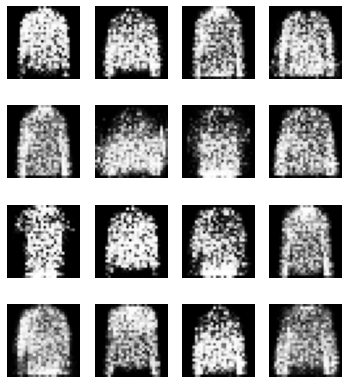

In [14]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### WGAN

In [22]:
for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
      for _ in range(critic_iterations):
        critic.zero_grad()
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        input_data = images.view(images.shape[0], -1)
        critic_real = critic(input_data)
        critic_fake = critic(fake)
        loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
        loss_critic.backward(retain_graph=True)
        optim_C.step()

        for p in critic.parameters():
          p.data.clamp_(-weight_clip, weight_clip)
      
      generator.zero_grad()
      label.data.fill_(real_label)
      output = critic(fake)
      loss_gen = -torch.mean(output)
      loss_gen.backward()
      optim_G.step()

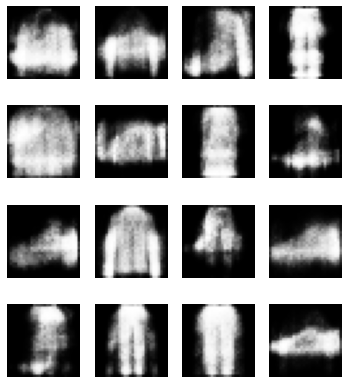

In [23]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### WGAN-GP

In [51]:
def gradient_penalty(critic, real, fake, device='cpu'):
  batch_size, c = real.shape
  epsilon = torch.rand((batch_size, 1)).repeat(1, c).to(device)
  interpolated_images = real * epsilon + fake * (1 - epsilon)

  mixed_scores = critic(interpolated_images)

  gradient = torch.autograd.grad(
      inputs=interpolated_images,
      outputs=mixed_scores,
      grad_outputs=torch.ones_like(mixed_scores),
      create_graph=True,
      retain_graph=True
  )[0]

  gradient = gradient.view(gradient.shape[0], -1)
  gradient_norm = gradient.norm(2, dim=1)
  gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
  return gradient_penalty

In [52]:
optim_gen = optim.Adam(params=generator.parameters(), lr=0.0001, betas=(0.0, 0.9))
optim_cri = optim.Adam(params=critic.parameters(), lr=0.0001, betas=(0.0, 0.9))

In [53]:
for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
      for _ in range(critic_iterations):
        critic.zero_grad()
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        input_data = images.view(images.shape[0], -1)
        critic_real = critic(input_data)
        critic_fake = critic(fake)
        gp = gradient_penalty(critic, input_data, fake, device)
        loss_critic = (
            -(torch.mean(critic_real) - torch.mean(critic_fake)) + lambda_gp * gp
        )
        loss_critic.backward(retain_graph=True)
        optim_cri.step()
      
      generator.zero_grad()
      label.data.fill_(real_label)
      output = critic(fake)
      loss_gen = -torch.mean(output)
      loss_gen.backward()
      optim_gen.step()

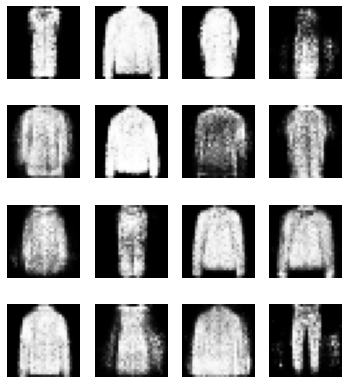

In [54]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

The aforeconducted experiments have shown:

1) WGAN provides higher stability in comparison with GAN (clearly seen from the visualizations), as WGANs leverages
the Wasserstein distance to produce a value function which has better theoretical properties than the
original. Hence, we obrained such results by the experiments and eventually proved the theory;

2) Since weight-clipping can lead to undesired results, gradient-penalty approach has been proposed as it does not suffer from the problems of weight-clipping. As a result, the second approach, using gradient-penalty, shows more convergence as it could be seen from the plots. Hence, indeed, it could be treated as more successful point.